<a href="https://colab.research.google.com/github/jeremyliweishih/150-DNN-Final/blob/master/dropoutasbayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# File setup from Github:

In [1]:
!pip install -q xlrd
!rm -f -r 150-DNN-Final
!git clone https://github.com/jeremyliweishih/150-DNN-Final


Cloning into '150-DNN-Final'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 425 (delta 23), reused 0 (delta 0), pack-reused 386
Receiving objects: 100% (425/425), 10.98 MiB | 8.02 MiB/s, done.
Resolving deltas: 100% (239/239), done.


In [2]:
# Files from the cloned git repository.
!ls 150-DNN-Final/

BBB	 BCNN-BBB.ipynb  DNN_Proposal.pdf      README.md
BBB_old  CNN.ipynb	 dropoutasbayes.ipynb


In [3]:
#need to upload kaggle auth token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fverac01","key":"ebe24a291467c06c9728b80bc0aa514f"}'}

In [0]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000  

100% 2.62G/2.62G [00:56<00:00, 67.7MB/s]
100% 2.62G/2.62G [00:56<00:00, 49.8MB/s]


In [7]:
!unzip skin-cancer-mnist-ham10000.zip

Archive:  skin-cancer-mnist-ham10000.zip
  inflating: hmnist_28_28_RGB.csv    
  inflating: HAM10000_metadata.csv   
  inflating: HAM10000_images_part_1.zip  
  inflating: hmnist_28_28_L.csv      
  inflating: hmnist_8_8_L.csv        
  inflating: HAM10000_images_part_2.zip  
  inflating: hmnist_8_8_RGB.csv      


In [8]:
!unzip HAM10000_images_part_1.zip
!unzip HAM10000_images_part_2.zip

Archive:  HAM10000_images_part_1.zip
  inflating: ISIC_0024306.jpg        
  inflating: ISIC_0024307.jpg        
  inflating: ISIC_0024308.jpg        
  inflating: ISIC_0024309.jpg        
  inflating: ISIC_0024310.jpg        
  inflating: ISIC_0024311.jpg        
  inflating: ISIC_0024312.jpg        
  inflating: ISIC_0024313.jpg        
  inflating: ISIC_0024314.jpg        
  inflating: ISIC_0024315.jpg        
  inflating: ISIC_0024316.jpg        
  inflating: ISIC_0024317.jpg        
  inflating: ISIC_0024318.jpg        
  inflating: ISIC_0024319.jpg        
  inflating: ISIC_0024320.jpg        
  inflating: ISIC_0024321.jpg        
  inflating: ISIC_0024322.jpg        
  inflating: ISIC_0024323.jpg        
  inflating: ISIC_0024324.jpg        
  inflating: ISIC_0024325.jpg        
  inflating: ISIC_0024326.jpg        
  inflating: ISIC_0024327.jpg        
  inflating: ISIC_0024328.jpg        
  inflating: ISIC_0024329.jpg        
  inflating: ISIC_0024330.jpg        
  inflating: 

# Load images: 
loading code creds: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools


In [0]:
base_skin_dir = os.path.join('./', '')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [11]:
#load images and fillna
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df['cell_type_idx'] = skin_df['cell_type_idx'].apply(lambda x: int(x))
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [12]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[189, 149, 186], [192, 154, 193], [199, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 15, 26], [60, 42, 68], [107, 81, 116], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[186, 134, 147], [198, 146, 159], [196, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[32, 16, 27], [88, 57, 73], [128, 80, 96], [..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[153, 111, 133], [189, 143, 172], [208, 158,..."


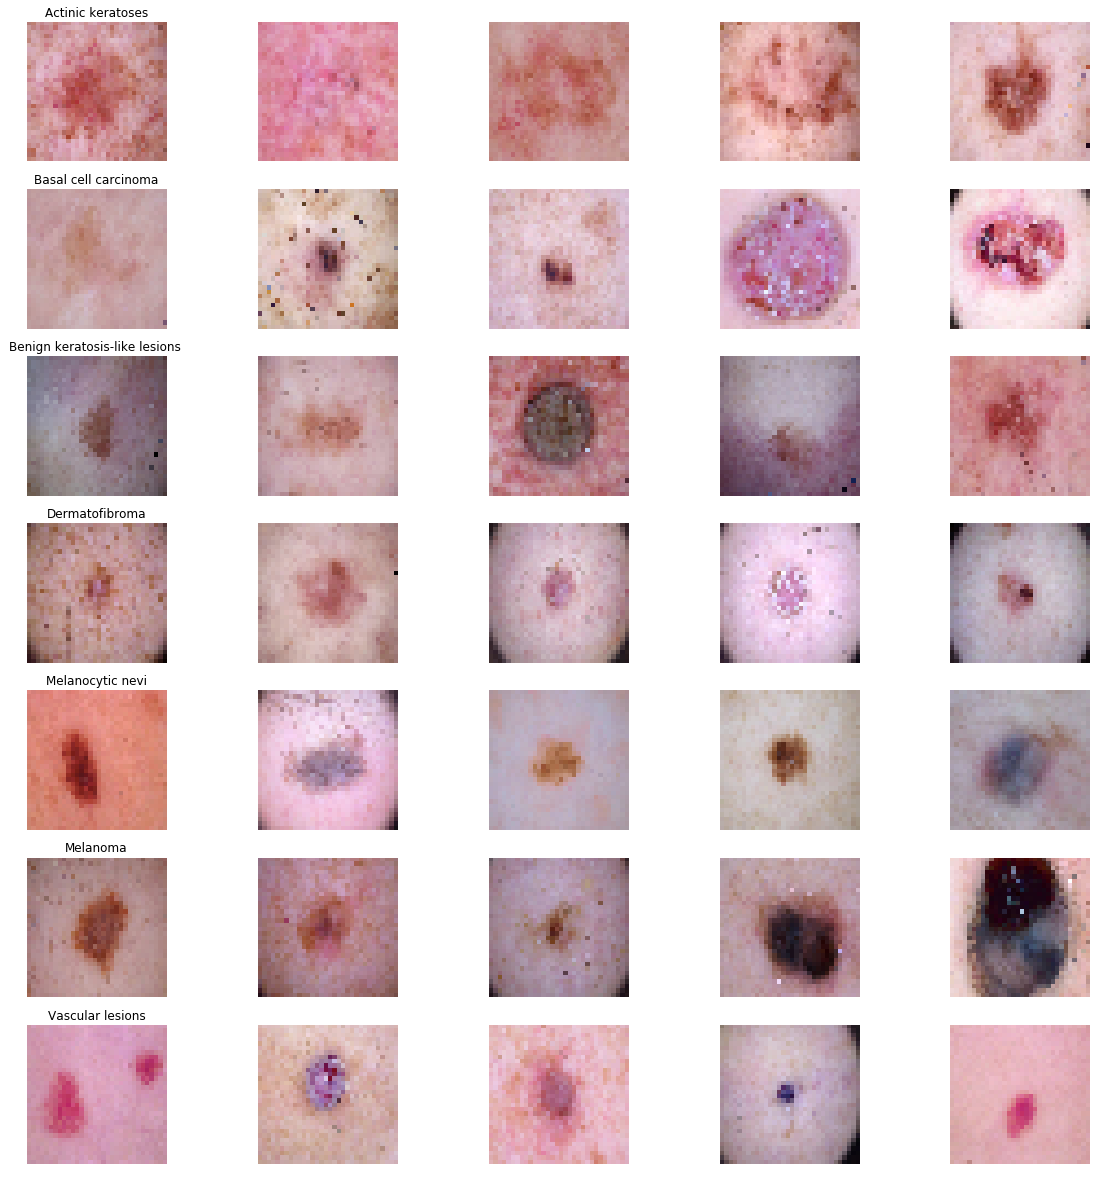

In [13]:
#check samples
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

# Pytorch Custom Dataset:

In [0]:
from torch.utils.data.dataset import Dataset
import torchvision
import torchvision.transforms as transforms

class CustomDatasetFromImages(Dataset):
    def __init__(self, df, transforms=None):
        """
        Args:
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Tensor Transform
#         self.to_tensor = transforms.ToTensor()
        self.transforms = transforms
        # Read the csv file
        self.dataset = df
        # 10th column contains the images
        self.image_arr = np.asarray(self.dataset.iloc[:, 10])
        # 9th column is the labels
        self.label_arr = np.asarray(self.dataset.iloc[:, 9])
        # Calculate len
        self.data_len = len(self.dataset.index)

    def __getitem__(self, index):
        # Open image
        img_as_np = self.image_arr[index]
        img_as_img = Image.fromarray(img_as_np)

#         # Transform image to tensor
#         img_as_tensor = self.to_tensor(img_as_img)
        
        if self.transforms:
                  img_as_tensor = self.transforms(img_as_img)

        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

# Setup NN

In [15]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical


Using TensorFlow backend.


In [0]:
import sys
sys.path.append('/content/150-DNN-Final/BBB/')




from __future__ import print_function

import os
# import sys
import time
import argparse
import datetime
import math
import pickle


import torchvision
import torchvision.transforms as transforms
from utils.autoaugment import CIFAR10Policy

import torch
import torch.utils.data as data
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler




# from utils.NonBayesianModels import conv_init
# from utils.NonBayesianModels.ThreeConvThreeFC import ThreeConvThreeFC



In [0]:
from utils.BBBlayers import FlattenLayer


def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform(m.weight, gain=np.sqrt(2))
        #nn.init.normal_(m.weight, mean=0, std=1)
        nn.init.constant(m.bias, 0)

class ThreeConvThreeFC(nn.Module):
    """
    To train on CIFAR-10:
    https://arxiv.org/pdf/1207.0580.pdf
    """
    def __init__(self, outputs, inputs):
        super(ThreeConvThreeFC, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(inputs, 32, 5, stride=1, padding=2),
            nn.Dropout2d(p = 0.25),
            nn.Softplus(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, 5, stride=1, padding=2),
            nn.Dropout2d(p = 0.25),
            nn.Softplus(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 128, 5, stride=1, padding=1),
            nn.Dropout2d(p = 0.25),
            nn.Softplus(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            FlattenLayer(2 * 2 * 128),
            nn.Linear(2 * 2 * 128, 1000),
            nn.Softplus(),
            nn.Dropout2d(p = 0.25),
            nn.Linear(1000, 1000),
            nn.Softplus(),
            nn.Dropout2d(p = 0.25),
            nn.Linear(1000, outputs)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        #print('X', x)
        return x

In [0]:
dataset = 'HAM10000'
outputs = 7
inputs = 3
n_epochs = 100
lr = 0.001
resize=32

In [0]:
# Hyper Parameter settings
use_cuda = torch.cuda.is_available()
torch.cuda.set_device(0)


In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2



In [0]:


# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])



In [0]:


features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

train_data, test_data = train_test_split(skin_df, test_size=0.20,random_state=1234)



In [0]:
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)



In [24]:
train_data.head()
test_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000628,ISIC_0024567,nv,follow_up,35.0,female,lower extremity,./ISIC_0024567.jpg,Melanocytic nevi,4,"[[[208, 115, 133], [211, 119, 142], [212, 122,..."
1,HAM_0004226,ISIC_0032760,nv,histo,25.0,female,trunk,./ISIC_0032760.jpg,Melanocytic nevi,4,"[[[55, 45, 56], [102, 86, 99], [125, 108, 126]..."
2,HAM_0002015,ISIC_0034035,nv,histo,30.0,female,lower extremity,./ISIC_0034035.jpg,Melanocytic nevi,4,"[[[148, 136, 160], [158, 147, 164], [161, 147,..."
3,HAM_0001651,ISIC_0033251,nv,histo,45.0,male,back,./ISIC_0033251.jpg,Melanocytic nevi,4,"[[[117, 103, 120], [129, 115, 130], [131, 117,..."
4,HAM_0003206,ISIC_0025199,bkl,histo,60.0,female,lower extremity,./ISIC_0025199.jpg,Benign keratosis-like lesions,2,"[[[190, 172, 184], [187, 166, 175], [188, 168,..."


In [0]:


train_set = CustomDatasetFromImages(train_data, transforms=transform)
test_set = CustomDatasetFromImages(test_data, transforms=transform)



In [0]:


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
    num_workers=num_workers)



In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

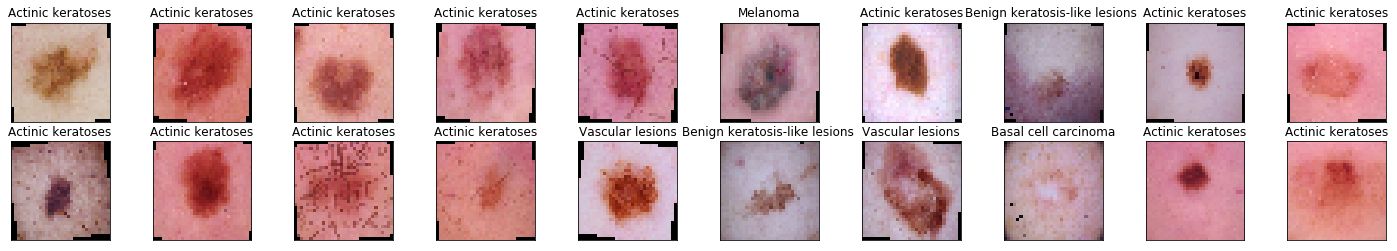

In [28]:
classes = ('Melanocytic nevi', 'Melanoma', 'Benign keratosis-like lesions ', 'Basal cell carcinoma',
            'Actinic keratoses', 'Vascular lesions', 'Dermatofibroma')

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
net = ThreeConvThreeFC(outputs,inputs)

In [0]:
# move tensors to GPU if CUDA is available
if use_cuda:
    net.cuda()

In [0]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(net.parameters(), lr=lr)


In [32]:

net_type = 'conv'
ckpt_name = f'model_{net_type}_{dataset}_frequentist.pt'
ckpt_name



'model_conv_HAM10000_frequentist.pt'

In [33]:
%%time

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    net.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    net.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net.state_dict(), ckpt_name)
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.934505 	Validation Loss: 0.213822
Validation loss decreased (inf --> 0.213822).  Saving model ...
Epoch: 2 	Training Loss: 0.855531 	Validation Loss: 0.205466
Validation loss decreased (0.213822 --> 0.205466).  Saving model ...
Epoch: 3 	Training Loss: 0.836881 	Validation Loss: 0.230754
Epoch: 4 	Training Loss: 0.811232 	Validation Loss: 0.208219
Epoch: 5 	Training Loss: 0.802699 	Validation Loss: 0.210796
Epoch: 6 	Training Loss: 0.770148 	Validation Loss: 0.210047
Epoch: 7 	Training Loss: 0.762000 	Validation Loss: 0.210134
Epoch: 8 	Training Loss: 0.741598 	Validation Loss: 0.199829
Validation loss decreased (0.205466 --> 0.199829).  Saving model ...
Epoch: 9 	Training Loss: 0.736663 	Validation Loss: 0.181599
Validation loss decreased (0.199829 --> 0.181599).  Saving model ...
Epoch: 10 	Training Loss: 0.718002 	Validation Loss: 0.180793
Validation loss decreased (0.181599 --> 0.180793).  Saving model ...
Epoch: 11 	Training Loss: 0.717153 	Validation Lo

In [0]:
net.load_state_dict(torch.load(ckpt_name))

In [35]:
%%time

# track test loss# track  
test_loss = 0.0
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))

net.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = net(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        if i >= target.data.shape[0]: # batch_size could be greater than left number of images
            break
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(7):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.727306

Test Accuracy of Melanocytic nevi:  5% ( 3/60)
Test Accuracy of Melanoma: 49% (48/97)
Test Accuracy of Benign keratosis-like lesions : 39% (89/224)
Test Accuracy of Basal cell carcinoma:  0% ( 0/27)
Test Accuracy of Actinic keratoses: 96% (1279/1320)
Test Accuracy of Vascular lesions:  8% (20/246)
Test Accuracy of Dermatofibroma: 75% (22/29)

Test Accuracy (Overall): 72% (1461/2003)
CPU times: user 537 ms, sys: 46 ms, total: 583 ms
Wall time: 589 ms


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
print(variances.shape)
variances

(2003,)


array([67.77552795,  4.02617884,  1.72640705, ...,  0.83346903,
        1.7276032 ,  1.18141103])

In [67]:
model = net
# model.train()

class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))


#set dropout layers to train mode
def apply_dropout(m):
    if type(m) == nn.Dropout2d:
        m.train()
model.eval()
model.apply(apply_dropout)


test_loss = 0
correct_sum = 0
T = 100

variances = np.array([])

for data, target in test_loader:
  if use_cuda:
    data, target = data.cuda(), target.cuda()
  data, target = Variable(data, volatile=True), Variable(target)
  output_list = []
  for i in range(T):
    output_list.append(torch.unsqueeze(model(data), 0))
  
  output_mean = torch.cat(output_list, 0).mean(0)
  output_torch = torch.cat(output_list, 0)
  batch_var = output_torch.var(0).mean(1)
  batch_var_np = batch_var.cpu().detach().numpy()
  variances = np.append(variances, batch_var_np)
  
  
  test_loss += F.nll_loss(F.log_softmax(output_mean), target, size_average=False).data#[0]  # sum up batch loss
  pred = output_mean.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct_sum += correct_tensor.cpu().sum()
  correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
  # calculate test accuracy for each object class
  for i in range(batch_size):
      if i >= target.data.shape[0]: # batch_size could be greater than left number of images
          break
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
      
  
  

for i in range(7):
  if class_total[i] > 0:
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
          classes[i], 100 * class_correct[i] / class_total[i],
          np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

  

test_loss /= len(test_loader.dataset)
print('\nMC Dropout Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct_sum, len(test_loader.dataset), 100. * correct_sum / len(test_loader.dataset)))

Test Accuracy of Melanocytic nevi:  0% ( 0/60)
Test Accuracy of Melanoma: 56% (55/97)
Test Accuracy of Benign keratosis-like lesions : 49% (110/224)
Test Accuracy of Basal cell carcinoma:  0% ( 0/27)
Test Accuracy of Actinic keratoses: 95% (1266/1320)
Test Accuracy of Vascular lesions:  8% (22/246)
Test Accuracy of Dermatofibroma: 62% (18/29)

Test Accuracy (Overall): 73% (1471/2003)

MC Dropout Test set: Average loss: 0.6939, Accuracy: 1471/2003 (73.00%)



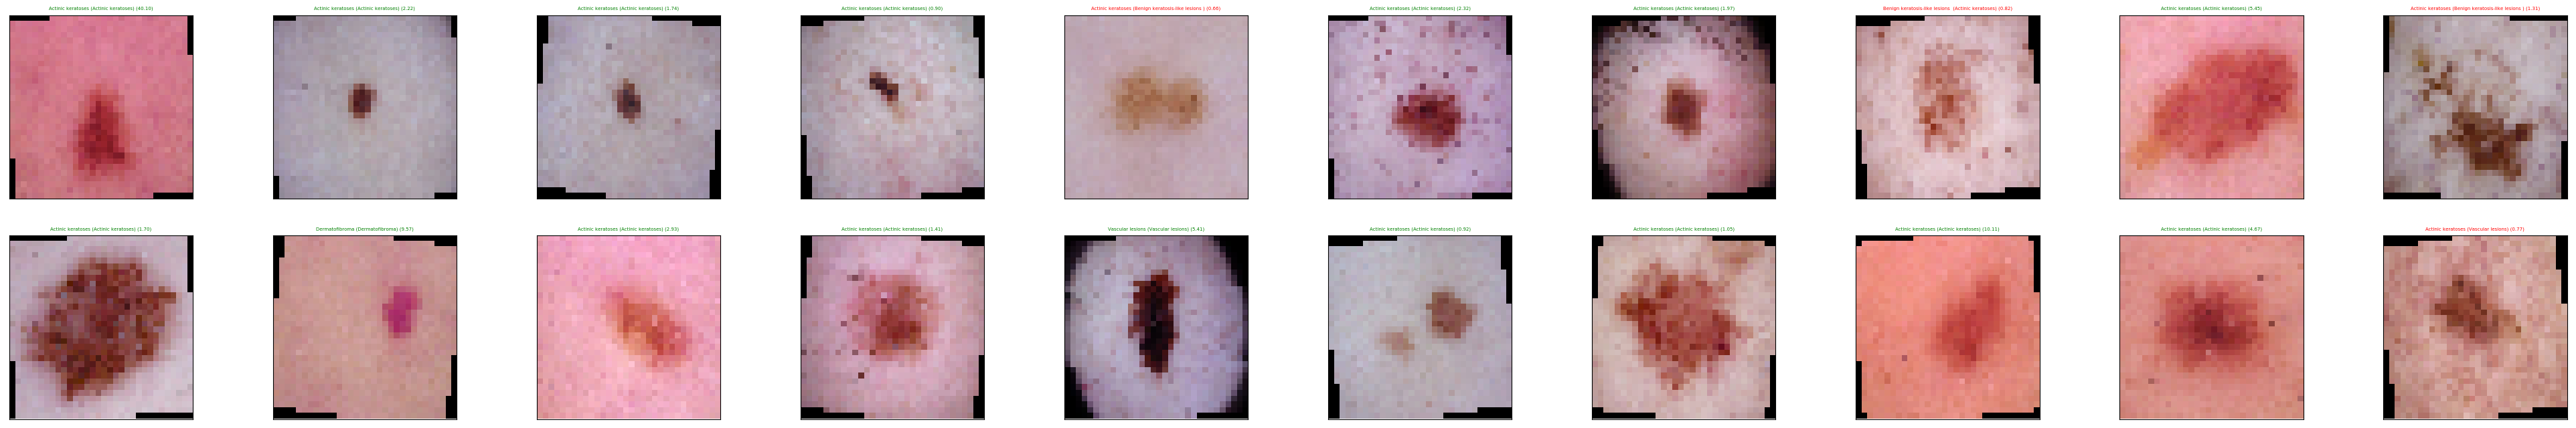

In [63]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100


# obtain one batch of test images
dataiter = iter(test_loader)
data, target = dataiter.next()
data.numpy()

if use_cuda:
  data, target = data.cuda(), target.cuda()
  
output_list = []
for i in range(T):
  output_list.append(torch.unsqueeze(model(data), 0))
  
output_mean = torch.cat(output_list, 0).mean(0)
output_torch = torch.cat(output_list, 0)
batch_var = output_torch.var(0).mean(1)
batch_var_np = batch_var.cpu().detach().numpy()
# variances = np.append(variances, batch_var_np)

test_loss += F.nll_loss(F.log_softmax(output_mean), target, size_average=False).data#[0]  # sum up batch loss
preds = output_mean.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
# correct += pred.eq(target.data.view_as(pred)).cpu().sum()


batch_var_np = ["{:.2f}".format(x) for x in batch_var_np]

preds = np.squeeze( preds.cpu().numpy() )
target = target.cpu().numpy()
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(50, 8))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    image = data[idx].cpu()
    imshow(image)
    ax.set_title("{} ({}) ({})".format(classes[preds[idx]], classes[target[idx]], batch_var_np[idx]),
                 color=("green" if preds[idx]==target[idx].item() else "red"),
                fontsize=5)




In [62]:
np.mean(variances)

5.939382280133334